In [1]:
from jax import jacobian, random, config
import jax.numpy as jnp
import jax.scipy as jsp
from diffrax import ODETerm, Dopri5, diffeqsolve, SaveAt, PIDController, Kvaerno5
from jaxtyping import Array, Int, Float
import matplotlib.pyplot as plt

key = random.PRNGKey(758493)

config.update("jax_enable_x64", True)

### Define relevant constants

In [2]:
omega_0 = jnp.sqrt(0.44022)
e0 = 0.95289
viscosity = 1

U = 1e4  # finite upper bound for numerical integration over [0, infty]
n_disc = int(1e6)  # number of discretization points per integral

step_size = 1e-1


eps = 1e-3
e = 0.94
a_0 = jnp.array(
    [
        (1 - e**2) ** (-1 / 6) * (1 + eps),
        (1 - e**2) ** (-1 / 6) / (1 + eps),
        (1 - e**2) ** (1 / 3),
    ]
)

T = 3
a_0

Array([1.43254601, 1.42968521, 0.48825983], dtype=float64)

### Set up numerical index symbols and corresponding derivative

In [3]:
def index_symbol(a: Array) -> Array:
    """
    Input: a [shape (3,)]
    Output: Index symbols A [shape (3,)]
    """
    assert a.shape == (3,)
    u = jnp.expand_dims(jnp.linspace(0, U, n_disc), axis=1)

    integrand = (a[0] * a[1] * a[2]) / (
        (a**2 + u) * jnp.sqrt((a[0] ** 2 + u) * (a[1] ** 2 + u) * (a[2] ** 2 + u))
    )
    return jsp.integrate.trapezoid(integrand.T, u.flatten())


def d_index_symbol_analytic(a: Array) -> Array:
    u = jnp.expand_dims(jnp.linspace(0, U, n_disc), axis=1)

    def _d_diagonal(i: Int) -> Float:
        j = (i + 1) % 3
        k = (i + 2) % 3
        integrand = (
            -a[j]
            * a[k]
            * (2 * a[i] ** 2 - u)
            / (
                jnp.sqrt(u**2 + (a[j] ** 2 + a[k] ** 2) * u + a[j] ** 2 * a[k] ** 2)
                * jnp.sqrt(a[i] ** 2 + u)
                * (a[i] ** 4 + 2 * u * a[i] ** 2 + u**2)
            )
        )
        return jsp.integrate.trapezoid(integrand.T, u.flatten())

    def _d_off_diagonal(i: Int, j: Int) -> Float:
        k = 3 - (i + j)
        integrand = (a[i] * a[k] * u) / (
            (u + a[i] ** 2)
            * jnp.sqrt(u**2 + (a[k] ** 2 + a[i] ** 2) * u + (a[i] ** 2 * a[k] ** 2))
            * ((a[j] ** 2 + u) ** (3 / 2))
        )
        return jsp.integrate.trapezoid(integrand.T, u.flatten())

    dA = jnp.zeros((3, 3))
    rows = [
        [_d_diagonal(i) if i == j else _d_off_diagonal(i, j) for j in range(3)]
        for i in range(3)
    ]
    dA = jnp.array(rows)
    dA = jnp.squeeze(dA)
    return dA


def d_index_symbol(a: Array) -> Array:
    """
    Input: a [shape (3,)]
    Output: derivative matrix dA [shape (3,3)]
    with dA[i,j] = \partial A_i / \partial a_j (0-indexed)
    """
    return jacobian(index_symbol)(a)

In [4]:
abs(
    d_index_symbol_analytic(jnp.array([3.2, 2.2, 1.5]))
    - d_index_symbol(jnp.array([3.2, 2.2, 1.5]))
)

Array([[5.55111512e-17, 5.55111512e-17, 5.55111512e-17],
       [0.00000000e+00, 8.32667268e-17, 5.55111512e-17],
       [1.52655666e-16, 5.55111512e-17, 5.55111512e-17]], dtype=float64)

### Define coefficients

In [5]:
def _Sigma(sign: Int, a: Array, A: Array) -> Float:
    """
    Private helper for computing lambda and omega, defined such that
    Sigma(1) = (Lambda + Omega)^2, Sigma(-1) = (Lambda - Omega)^2
    """
    assert abs(sign) == 1
    return 2 * (
        (a[0] * A[0] - sign * a[1] * A[1]) / (a[0] - sign * a[1])
        + sign * (a[2] ** 2) * A[2] / (a[0] * a[1])
    )


def Lambda(a: Array, A: Array) -> Float:  ### vorticity
    return (1 / 2) * (jnp.sqrt(_Sigma(1, a, A)) + jnp.sqrt(_Sigma(-1, a, A)))


def Omega(a: Array, A: Array) -> Float:  ### angular velocity
    return (1 / 2) * (jnp.sqrt(_Sigma(1, a, A)) - jnp.sqrt(_Sigma(-1, a, A)))

In [6]:
### Sanity checks for Lambda and Omega

assert (
    jnp.abs(
        (Lambda(a_0, index_symbol(a_0)) - Omega(a_0, index_symbol(a_0))) ** 2
        - _Sigma(-1, a_0, index_symbol(a_0))
    )
    < eps
)
assert (
    jnp.abs(
        (Lambda(a_0, index_symbol(a_0)) + Omega(a_0, index_symbol(a_0))) ** 2
        - _Sigma(1, a_0, index_symbol(a_0))
    )
    < eps
)

In [7]:
def _Q(alpha: Int, epsilon: Int, a: Array, A: Array, dA: Array) -> Float:
    """
    Helper function for computing b_i coefficients (from Detweiler and Lindblom)
    """
    assert alpha in [1, 2]
    assert abs(epsilon) == 1
    sgn = -1 if alpha == 1 and epsilon == -1 else 1
    alpha -= 1
    beta = alpha ^ 1

    return (
        A[alpha]
        + a[alpha] * dA[alpha, alpha]
        + epsilon * a[beta] * dA[beta, alpha]
        - a[2] * dA[alpha, 2]
        - a[2] * a[beta] * dA[beta, 2] / a[alpha]
        - (a[0] * A[0] + epsilon * a[1] * A[1]) / (a[0] + epsilon * a[1])
        + (
            sgn
            * (a[0] + epsilon * a[1])
            * (3 * A[2] + a[2] * dA[2, 2] - a[alpha] * dA[2, alpha])
            * (a[2] ** 2)
            / ((a[alpha] ** 2) * a[beta])
        )
        + 2 * ((Lambda(a, A) - epsilon * Omega(a, A)) ** 2)
    ) / (Lambda(a, A) - epsilon * Omega(a, A))

In [8]:
def _b(a: Array):
    A = index_symbol(a)
    dA = d_index_symbol(a)

    def _b0() -> Float:
        return (
            -5
            * Lambda(a, A)
            * ((a[0] ** 2) - (a[1] ** 2))
            / ((a[0] ** 2) * (a[1] ** 2))
            * (_Q(2, 1, a, A, dA) * (a[0] + a[1]) + _Q(2, -1, a, A, dA) * (a[0] - a[1]))
            / (
                _Q(1, 1, a, A, dA) * _Q(2, -1, a, A, dA)
                + _Q(1, -1, a, A, dA) * _Q(2, 1, a, A, dA)
            )
        )

    def _b1() -> Float:
        return (
            -5
            * Lambda(a, A)
            * ((a[0] ** 2) - (a[1] ** 2))
            / ((a[0] ** 2) * (a[1] ** 2))
            * (_Q(1, -1, a, A, dA) * (a[0] - a[1]) - _Q(1, 1, a, A, dA) * (a[0] + a[1]))
            / (
                _Q(1, 1, a, A, dA) * _Q(2, -1, a, A, dA)
                + _Q(1, -1, a, A, dA) * _Q(2, 1, a, A, dA)
            )
        )

    def _b2() -> Float:
        return -a[2] * (_b0() / a[0] + _b1() / a[1])

    return jnp.stack([_b0(), _b1(), _b2()])

### Timing

In [9]:
# %%time
# for i in range(100):
#     index_symbol(random.uniform(key, shape=(3,)))

In [10]:
# %%time
# for i in range(100):
#     d_index_symbol(random.uniform(key, shape=(3,)))

In [11]:
# %%time
# for i in range(100):
#     d_index_symbol_analytic(random.uniform(key, shape=(3,)))

In [12]:
# %%time

# for i in range(100):
#     arand = random.uniform(key, shape=(3,))
#     _Q(1, -1, arand, index_symbol(arand), d_index_symbol(arand))
# # jnp.array([4.0, 2.0, 1.0]))
# # the precision of the Q's vs mathematica was a good way to test the values of U, n_disc
# # with a perturbation of 1e-5, U=1e4, n_disc=1e6 I was getting way off when epsilon=-1

In [13]:
# %%time
# for i in range(100):
#     _b(random.uniform(key, shape=(3,)))

### Solve ODE

In [ ]:
def coeffs(t, a, args):
    nu = args[0]
    return nu * _b(a)


term = ODETerm(coeffs)
solver = Kvaerno5()

stepsize_controller = PIDController(
    rtol=1e-6,
    atol=1e-9,  # tolerances
    pcoeff=0.3,  # proportional gain
    icoeff=0.3,  # integral gain
    # dcoeff=0.0,  # derivative gain (often zero)
    # dtmin=1e-12,
    # dtmax=1.0,  # optional caps on dt
    # safety=0.9,  # safety factor; default exists
)

solution = diffeqsolve(
    term,
    solver,
    t0=0.0,
    t1=T,
    dt0=step_size,
    y0=a_0,
    args=(viscosity,),
    stepsize_controller=stepsize_controller,
    saveat=SaveAt(ts=jnp.linspace(0, T, int(T / step_size))),
    max_steps=2**16,
)
# 5) Grab time-series
ts = solution.ts
ys = solution.ys

In [ ]:
ys

Array([[1.432546  , 1.4296852 , 0.48825982],
       [1.4325747 , 1.4296565 , 0.48825988],
       [1.432604  , 1.4296273 , 0.48825994],
       [1.4326336 , 1.4295975 , 0.48826   ],
       [1.432664  , 1.4295672 , 0.48826006],
       [1.4326949 , 1.4295363 , 0.4882601 ],
       [1.4327265 , 1.4295048 , 0.48826012],
       [1.4327588 , 1.4294726 , 0.48826015],
       [1.4327917 , 1.4294397 , 0.48826018],
       [1.4328251 , 1.4294059 , 0.4882602 ],
       [1.4328594 , 1.4293717 , 0.48826024],
       [1.4328941 , 1.4293368 , 0.48826027],
       [1.4329298 , 1.4293013 , 0.4882603 ],
       [1.4329661 , 1.429265  , 0.48826033],
       [1.4330031 , 1.429228  , 0.48826036],
       [1.4330407 , 1.4291902 , 0.48826042],
       [1.4330792 , 1.4291517 , 0.48826048],
       [1.4331187 , 1.4291123 , 0.48826054],
       [1.4331586 , 1.4290723 , 0.4882606 ],
       [1.4331995 , 1.4290313 , 0.48826066],
       [1.4332411 , 1.4289893 , 0.48826072],
       [1.4332837 , 1.4289469 , 0.48826078],
       [1.

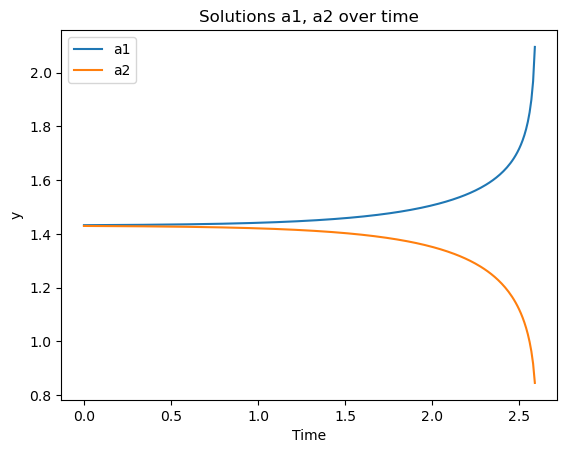

In [ ]:
plt.figure()
# plt.xlim(0, T)
plt.plot(ts, ys[:, 0], label="a1")
plt.plot(ts, ys[:, 1], label="a2")
plt.xlabel("Time")
plt.ylabel("y")
plt.title("Solutions a1, a2 over time")
plt.legend()
plt.show()

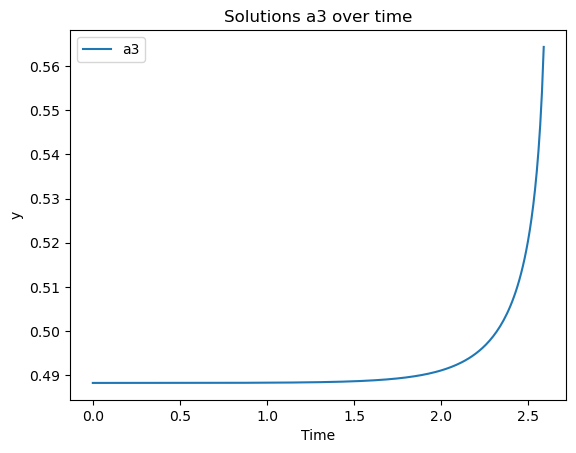

In [ ]:
plt.figure()
plt.plot(ts, ys[:, 2], label="a3")
plt.xlabel("Time")
plt.ylabel("y")
plt.title("Solutions a3 over time")
plt.legend()
plt.show()

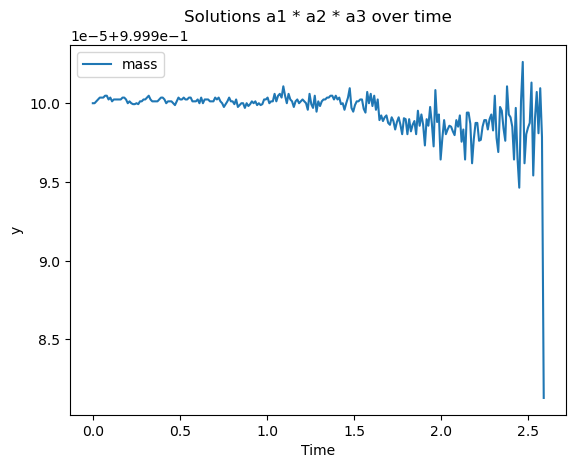

In [ ]:
plt.figure()
plt.plot(ts, ys[:, 0] * ys[:, 1] * ys[:, 2], label="mass")
plt.xlabel("Time")
plt.ylabel("y")
plt.title("Solutions a1 * a2 * a3 over time")
plt.legend()
plt.show()